<a href="https://colab.research.google.com/github/Jomp375/Sociophysics_2_model/blob/main/Copy_of_Model%2BMore_Forces%2BAnimationv4_(1).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Forces that are present in the model**
- A force that attracts people to the train door. (only active when +2m away from door)
- A force that forces people that are closely together to move away from each other. (only active when -2.5m distance from each other, only agents that are further away from train door are affected)
- A force that forces people away from the dangerzone. (only active -2m away from rails)
- A force that forces people away from the train door to make space for people leaving the train. (only active when y=10-20 and x=7.5-12.5)

**Forces that still need to be added to the model**
- ...


**Other things that are done**
- People entering the actual train via the door after everyone left the train.

**Other things that are still to be done**
- People leaving the train after a certain time.

**Entering of the train included!**

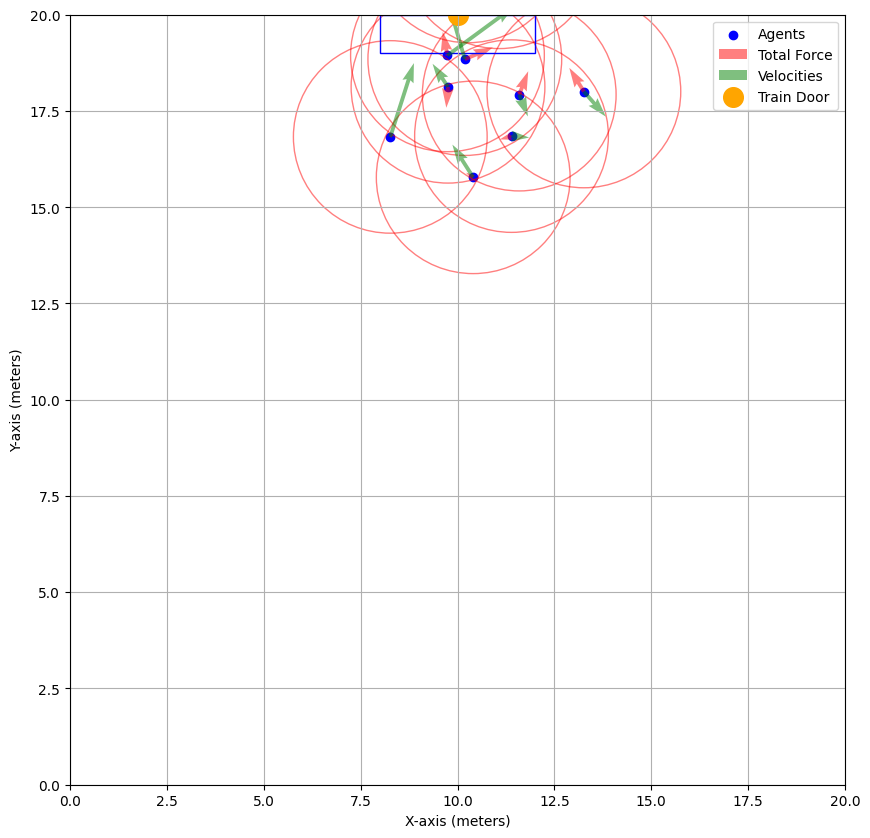

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon
import pandas as pd

# Set the size of the area
area_size = 20  # in meters

# Set the number of agents
num_agents = 20

# Set the radius of the circle around each agent
circle_radius = 2.5
interaction_force = 0.1

# Set the location of the train door
door_location = np.array([area_size/2, area_size])

# Set the distance for the constant force towards the train door
constant_force_distance = 2.0
constant_force_magnitude = 0.05
constant_force_magnitude_initial = constant_force_magnitude

# Set the initial distance between agents
initial_distance_agents = 1.5  # initial minimal spread

# Set the initial velocity range of agents
initial_velocity = 0.1

# Set the time step, number of timestamps and the constant for updating positions and velocities
num_timestamps = 250
start_leaving = 75
start_entering = 150
time_step = 1
kp = 1
kv = 0.5
damping_coefficient = 0.25  # Damping coefficient for realistic damping force

# Additional force for people standing between y=18 and y=20
dangerzone_force = 0.08

# Force to prevent blocking the train door
door_force_magnitude = 0.1

# Function to ensure agents are at least initial_distance_agents meters apart from each other
def generate_random_coordinates(num_agents, min_distance):
    coordinates = np.random.rand(num_agents, 2) * area_size
    for i in range(num_agents):
        for j in range(i):
            while np.linalg.norm(coordinates[i] - coordinates[j]) < min_distance:
                coordinates[i] = np.random.rand(2) * area_size
    return coordinates

# Function to calculate the force between two agents based on distance
def calculate_force(distance):
    # Linearly decreasing force from interaction_force to 0 for distances between 0 and circle_radius
    return interaction_force * (1 - distance / circle_radius)

# Initialize total force components for each agent
total_force_components = np.zeros((num_agents, 2))

# Generate random coordinates for the agents within the area (ensuring they are at least initial_distance_agents meters apart)
agent_coordinates = generate_random_coordinates(num_agents, initial_distance_agents)

# Randomize velocities to all directions and magnitudes between -1 and 1
agent_velocities = (np.random.rand(num_agents, 2) * 2 - 1) * initial_velocity  # Random values between -1 and 1 for both x and y

# Create a DataFrame to store the information
columns = ['ID', 'Time', 'X Position', 'Y Position', 'X Velocity', 'Y Velocity', 'X Force', 'Y Force', 'Type']
agent_data_animatie = pd.DataFrame(columns=columns)

# Main simulation loop
for timestamp in range(num_timestamps):
    # Calculate forces and directions for each agent
    for i in range(num_agents):
        total_force_components[i] = np.zeros(2)  # Reset total force components

        for j in range(num_agents):
            if i != j:
                # Calculate the distance between agents
                distance_vector = agent_coordinates[j] - agent_coordinates[i]
                distance = np.linalg.norm(distance_vector)

                # Check if the agent is farther from the door than a threshold before applying interaction force
                distance_to_door_agent_i = np.linalg.norm(agent_coordinates[i] - door_location)
                distance_to_door_agent_j = np.linalg.norm(agent_coordinates[j] - door_location)

                if distance < circle_radius and distance_to_door_agent_i > distance_to_door_agent_j:
                    # Calculate force magnitude
                    force_magnitude = calculate_force(distance)

                    # Calculate force direction (away from the agent providing the force)
                    force_direction = -distance_vector / distance

                    # Accumulate force components
                    total_force_components[i] += force_magnitude * force_direction

        # Constant force towards the train door
        distance_to_door = np.linalg.norm(agent_coordinates[i] - door_location)
        if timestamp < start_entering:
           constant_force_distance = 2.0  # Use the original value before time 150
        else:
           constant_force_distance = 0  # Set to 0 after time 150
           constant_force_magnitude = (2 - np.linalg.norm(agent_coordinates[i] - door_location) / 7)*constant_force_magnitude_initial

        # Constant force towards the train door
        distance_to_door = np.linalg.norm(agent_coordinates[i] - door_location)
        if distance_to_door >= constant_force_distance:
            force_direction_to_door = (door_location - agent_coordinates[i]) / distance_to_door
            total_force_components[i] += constant_force_magnitude * force_direction_to_door

        # Damping force to prevent large velocities
        damping_force = -damping_coefficient * agent_velocities[i]
        total_force_components[i] += damping_force

        # Additional force for people standing higher than y=18
        if area_size-2 <= agent_coordinates[i, 1]:
            if timestamp < start_entering or (timestamp >= start_entering and (agent_coordinates[i, 0] <= 9 or 11 <= agent_coordinates[i, 0])):
                total_force_components[i, 1] -= dangerzone_force * (agent_coordinates[i, 1] - area_size + 2)

        # Force to prevent blocking the train door
        if timestamp < start_entering:
           if 8 <= agent_coordinates[i, 0] <= 10 and 10 <= agent_coordinates[i, 1]:
            door_force = door_force_magnitude * ((agent_coordinates[i, 0] - 8) / 2)
            total_force_components[i, 0] -= door_force

           if 10 < agent_coordinates[i, 0] <= 12 and 10 <= agent_coordinates[i, 1]:
            door_force = door_force_magnitude * (-(agent_coordinates[i, 0] - 12) / 2)
            total_force_components[i, 0] += door_force

    # Update positions, velocities, and forces for each agent
    for i in range(num_agents):
        agent_coordinates[i] += kp * time_step * agent_velocities[i]
        agent_velocities[i] += kv * time_step * total_force_components[i]

    # Reset forces and set velocities for agents above area_size after time 150
    for i in range(num_agents):
        if timestamp >= start_entering and agent_coordinates[i, 1] > area_size:
            total_force_components[i] = np.zeros(2)  # Reset forces
            agent_velocities[i] = np.array([0.0, 0.2])  # Set the desired velocity

    # Store the information for each agent at the current timestamp
    timestamp_data = pd.DataFrame({
        'ID': np.arange(num_agents),
        'Time': timestamp + 1,
        'X Position': agent_coordinates[:, 0],
        'Y Position': agent_coordinates[:, 1],
        'X Velocity': agent_velocities[:, 0],
        'Y Velocity': agent_velocities[:, 1],
        'X Force': total_force_components[:, 0],
        'Y Force': total_force_components[:, 1],
        'Type': 'Blue'
    })

    agent_data_animatie = pd.concat([agent_data_animatie, timestamp_data], ignore_index=True)

# Plotting
fig, ax = plt.subplots(figsize=(10, 10))

# Plot agents
scatter = ax.scatter(agent_coordinates[:, 0], agent_coordinates[:, 1], marker='o', color='blue', label='Agents')

# Plot total force vectors for each agent as red arrows
quiver = ax.quiver(
    agent_coordinates[:, 0], agent_coordinates[:, 1],
    total_force_components[:, 0], total_force_components[:, 1],
    angles='xy', scale_units='xy', scale=0.1, alpha=0.5, color='red', width=0.005, label='Total Force'
)

# Draw a circle with variable radius and reduced color intensity
for i in range(num_agents):
    circle = plt.Circle((agent_coordinates[i, 0], agent_coordinates[i, 1]), circle_radius, color='red', fill=False, alpha=0.5)
    ax.add_patch(circle)

# Draw the train door box
door_vertices = np.array([(area_size/2-2, area_size-1), (area_size/2+2, area_size-1), (area_size/2+2, area_size), (area_size/2-2, area_size)])
door_box = Polygon(door_vertices, edgecolor='blue', facecolor='none')
ax.add_patch(door_box)

# Plot randomized velocities as arrows
ax.quiver(
    agent_coordinates[:, 0], agent_coordinates[:, 1],
    agent_velocities[:, 0], agent_velocities[:, 1],
    angles='xy', scale_units='xy', scale=0.1, alpha=0.5, color='green', width=0.005, label='Velocities'
)

# Add a marker at the initial door location
ax.scatter(door_location[0], door_location[1], marker='o', color='orange', s=200, label='Train Door')

# Set labels and show the plot
ax.set_xlim(0, area_size)
ax.set_ylim(0, area_size)
ax.set_xlabel('X-axis (meters)')
ax.set_ylabel('Y-axis (meters)')
ax.grid(True)
ax.legend()

# Display the plot
plt.show()


**Animation using the obtained data**

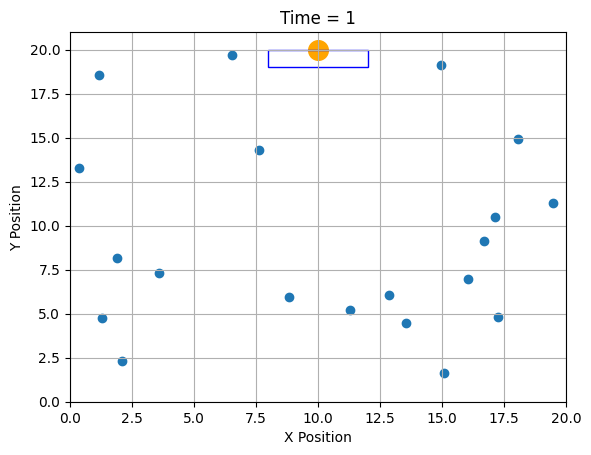

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from matplotlib.patches import Polygon
from IPython.display import HTML

# Assuming you have the agent_data_animatie DataFrame from the previous code

# Function to update the scatter plot in each frame of the animation
def update(frame):
    plt.clf()  # Clear the previous plot

    # Plot agents
    agent_data_frame = agent_data_animatie[agent_data_animatie['Time'] == frame]
    plt.scatter(agent_data_frame['X Position'], agent_data_frame['Y Position'], label='Agent Positions')

    # Add a marker as a train door
    plt.scatter(10, 20, marker='o', color='orange', s=200, label='Train Door')

    # Draw the train door box
    door_vertices = np.array([(area_size/2-2, area_size-1), (area_size/2+2, area_size-1), (area_size/2+2, area_size), (area_size/2-2, area_size)])
    door_box = Polygon(door_vertices, edgecolor='blue', facecolor='none')
    plt.gca().add_patch(door_box)

    # Set labels and show the plot
    plt.xlim(0, area_size)
    plt.ylim(0, area_size + 1)
    plt.xlabel('X Position')
    plt.ylabel('Y Position')
    plt.title(f'Time = {frame}')
    plt.grid(True)

# Set up the figure and axis
fig, ax = plt.subplots()

# Get unique time values from the DataFrame
unique_times = agent_data_animatie['Time'].unique()

# Create the animation
animation = FuncAnimation(fig, update, frames=unique_times, interval=50, repeat=False)

# Display the animation in Colab
html = HTML(animation.to_jshtml())
display(html)